# Lab — Self-supervised learning on graphs

### CORA Exploratory Data Analysis

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Let us take a closer look at this dataset.

In [34]:
import requests
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from tqdm import trange
from IPython.display import clear_output

In [35]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/cora_cites.txt'
open('cora_cites.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/cora_content.txt'
open('cora_content.txt', 'wb').write(requests.get(url).content);

Number of nodes in the graph

In [36]:
cora = nx.read_edgelist('cora_cites.txt', nodetype=int)
len(cora)

2708

Number of nodes in a gigantic connected component (GCC)

In [37]:
gcc_nodes = sorted(list(nx.connected_components(cora)), 
                   key=lambda x: len(x))[-1]
gcc_cora = cora.subgraph(gcc_nodes).copy()
len(gcc_cora)


2485

Nodes content

In [38]:
cora_content = pd.read_csv('cora_content.txt', sep='	', 
                           header=None, index_col=0)
cora_content = cora_content.loc[list(gcc_cora.nodes)]
cora_content.index.name = 'node'
cora_content.iloc[:5, :20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
node,,,,,,,,,,,,,,,,,,,,
35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1033,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
103482,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
103515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1050679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [39]:
cora_content.shape

(2485, 1434)

Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. In this assignment, we will only work with categories and will not touch any information about words.
Examples of node categories

In [40]:
category = cora_content.loc[:, [1434]]
category = category.rename(columns={1434: 'category_name'})
category.head()

,category_name
node,
35,Genetic_Algorithms
1033,Genetic_Algorithms
103482,Neural_Networks
103515,Genetic_Algorithms
1050679,Genetic_Algorithms


Category distribution

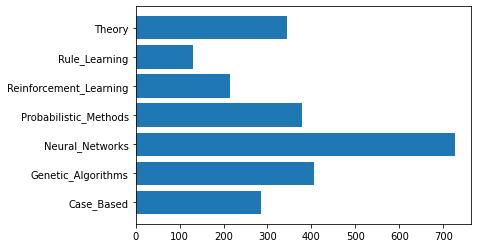

In [41]:
plt.barh(*np.unique(category, return_counts=True));

Let us rename categories to integer numbers (ids)

In [42]:
category['category_id'] = np.unique(category.category_name, 
                                    return_inverse = True)[1]
category.head()

,category_name,category_id
node,,
35,Genetic_Algorithms,1
1033,Genetic_Algorithms,1
103482,Neural_Networks,2
103515,Genetic_Algorithms,1
1050679,Genetic_Algorithms,1


Convert node labels into ordered integers

In [43]:
gcc_cora = nx.convert_node_labels_to_integers(gcc_cora)
cora_content.index = list(gcc_cora.nodes)
category.index = list(gcc_cora.nodes)

### DeepWalk baseline

In [44]:
!pip install karateclub -q

In [45]:
from karateclub import DeepWalk

In [46]:
baseline = DeepWalk(walk_number=10, walk_length=10, window_size=20, dimensions=128)
baseline.fit(gcc_cora)

In [47]:
z = baseline.get_embedding()
y = category['category_id'].values

In [48]:
z.shape, y.shape

((2485, 128), (2485,))

In [49]:
reduction = TSNE(n_components=2)
xy_emb = reduction.fit_transform(z)

In [50]:
xy_emb.shape

(2485, 2)

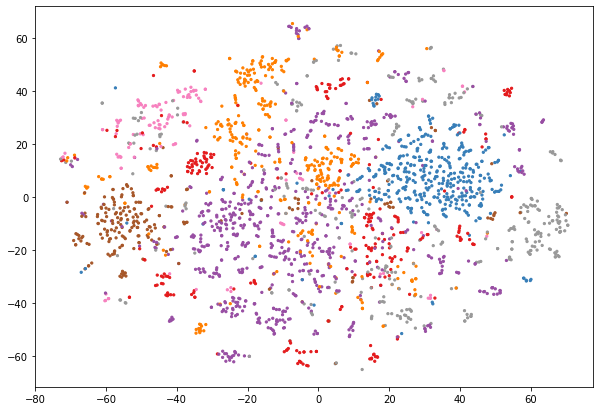

In [51]:
plt.figure(figsize=(10, 7))
plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=y, s=5, cmap=plt.cm.Set1)
plt.show()

In [52]:
z_train, z_test, y_train, y_test \
  = train_test_split(z, y, test_size=0.8, random_state=0)

In [53]:
clf = LogisticRegression(max_iter=1000)
clf.fit(z_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
clf.score(z_test, y_test)

0.6856136820925554

### Variational Graph Autoencoders

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/main/vgae.png' width=700>

Paper: https://arxiv.org/pdf/1611.07308.pdf

Definitions:
* $x$ — data
* $z$ — latent variable
* $p(x)$ — evidence probability
* $p(z)$ — prior probability
* $p(z|x)$ — posterior probability
* $p(x|z)$ — likelihood probability

Bayes theorem:

$$p(x,z) = p(x|z)p(z)$$
$$ p(x,z) = p(z|x)p(x)$$
$$\Rightarrow p(z|x)p(x) = p(x|z)p(z)$$
$$\Rightarrow p(x) = \frac{p(x|z)p(z)}{p(z|x)}$$

ELBO is an evidence lower bound

$$\log p\left(x\right) \geq \text{ELBO}$$

$$\text{ELBO} = -D_{K L}\left[p_{\theta}(z|x)\| p(z)\right]+E_{\sim p_{\theta}(z|x)}\left[\log p_{\phi}(x|z)\right]$$

Derivation: https://arxiv.org/pdf/1907.08956.pdf

For Gaussian prior and Gaussian posterior approximation, we have

$$\text{ELBO}=\sum_{j=1}^{J} \frac{1}{2}\left[1+\log \left(\sigma_{j}^{2}\right)-\sigma_{j}^{2}-\mu_{j}^{2}\right]+ E_{\sim p_{\theta}(z|x)}\left[\log p_{\phi}(x|z)\right]$$

where $J$ is the dimension of the latent vector $z$.

In [55]:
!pip install dgl==0.6.1 -q

In [56]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
import dgl
from dgl.nn import GraphConv

In [67]:
g = dgl.from_networkx(gcc_cora)
g = g.add_self_loop()
adj = g.adj().to_dense()
g.ndata['feat'] = torch.tensor(cora_content.iloc[:, :-1].values)
g

Graph(num_nodes=2485, num_edges=15108,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.int64)}
      edata_schemes={})

In [68]:
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv = GraphConv(input_dim, hidden_dim)
        self.mu = GraphConv(hidden_dim, output_dim)
        self.sigma = GraphConv(hidden_dim, output_dim)

    def forward(self, g, features):
        h = self.conv(g, features)
        h = F.relu(h)
        mu = self.mu(g, h)
        sigma = F.softplus(self.sigma(g, h))
        return mu, sigma

In [69]:
class InnerProductDecoder(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, z):
        return z @ z.T

In [70]:
n = g.number_of_nodes()
m = g.number_of_edges()
norm = n**2 / (n**2 - m) / 2
pos_weight = (n**2 - m) / m
weight = torch.ones(n, n)
weight[adj == 1] = pos_weight

In [71]:
emb_dim = 16
encoder = GaussianEncoder(1433, 32, emb_dim)
decoder = InnerProductDecoder()
opt = Adam(encoder.parameters(), lr=0.005)

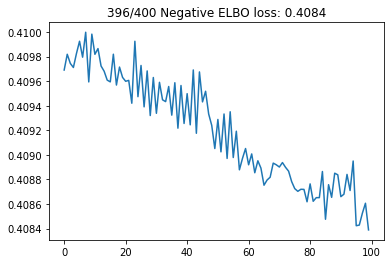

In [72]:
loss_vals = []
n_epochs = 400
for i in range(n_epochs):
    mu, sigma = encoder(g, g.ndata['feat'])
    z = torch.randn(n, emb_dim)
    z = z * sigma + mu

    logits = decoder(z)

    likelihood = -norm * F.binary_cross_entropy_with_logits(logits, adj, weight=weight)
    d_kl = -(1 + torch.log(sigma**2) - mu**2 - sigma**2) * 0.5 / n
    d_kl = d_kl.sum(1).mean()
    elbo = likelihood - d_kl
    loss = -elbo

    opt.zero_grad()
    loss.backward()
    opt.step()

    loss_vals.append(loss.item())

    if i % 5 == 0:
        plt.plot(loss_vals[-100:])
        plt.title('{}/{} Negative ELBO loss'.format(i+1, n_epochs))
        plt.show();
        clear_output(wait=True)

In [73]:
reduction = TSNE(n_components=2)
xy_emb = reduction.fit_transform(z.detach())

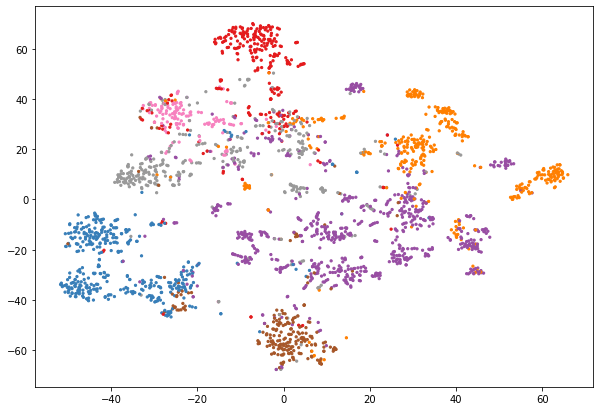

In [74]:
plt.figure(figsize=(10, 7))
plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=y, s=5, cmap=plt.cm.Set1)
plt.show()

In [75]:
z_train, z_test, y_train, y_test \
  = train_test_split(z.detach(), y, test_size=0.8, random_state=0)
clf = LogisticRegression(max_iter=1000)
clf.fit(z_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
clf.score(z_test, y_test)

0.7942655935613682